# Imports

In [1]:
import numpy as np
import cupy as cp
import pyquasar as pq

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

%config InlineBackend.figure_format='retina'

# Helmholtz equation with fixed frequency

$\Delta p + k^2 p = -j \rho_0 \omega q$

Dirichlet boundary condition:

$p = \hat p$

Neumann boundary condition:

$\nu_n = \frac{j}{\rho_0 \omega} \frac{\partial p}{\partial n} = \hat \nu_n$

Robin boundary condition:

$p = Z \nu_n = \frac{j}{\rho_0 \omega A} \frac{\partial p}{\partial n}$ 

where:
 - $\omega = 2 \pi f$;
 - $k = \frac{\omega}{c}$;
 - $c$ -- speed of sound;
 - $f$ -- frequency;
 - $\rho_0$ -- density;
 - $Z$ -- impedance;
 - $A$ -- ???;
 - $\nu_n$ -- normal velocity.

## Robin boundary condition

$a u + b \frac{\partial u}{\partial n} = g$

$\frac{\partial u}{\partial n} + \frac{a}{b} u = \frac{g}{b}$

$\lambda \frac{\partial u}{\partial n} + \beta (u - u_{\beta}) = 0$

$\lambda \frac{\partial u}{\partial n} + \beta u = \beta u_{\beta}$


$p = \frac{j}{\rho_0 \omega A} \frac{\partial p}{\partial n}$

$\frac{\partial p}{\partial n} - \frac{\rho_0 \omega A}{j} p = 0$

In [2]:
air = {"density": 1.21, "speed": 343, "impedance": 415}

In [3]:
f = 300
k = 2 * np.pi * f / air["speed"]
j = 1.0j

In [4]:
t = None

In [5]:
def u(t, p, n):
  return np.zeros_like(p[..., 0])


def source(t, p, n):
  # return j * air["density"] * 2 * np.pi
  # s = sin(2pi f t)
  # v = ds/dt = 2pi f cos(2pi f t)
  # vn = n v
  omega = 2 * np.pi * f
  return air["density"] * (omega) ** 2 * np.sin(omega * t) / (0.01)


def flow(p, n):
  return np.zeros_like(p[..., 0])


def ub(p, n):
  return 2 * (n[..., 0] - n[..., 1]) + p[..., 0] - p[..., 1]

In [6]:
device = "cuda"

In [7]:
mesh = pq.Mesh.load("cube.geo", refine_k=1)
domains = [pq.FemDomain(domain, device=device) for domain in mesh]
# problem = pq.FemProblem(domains, device="cuda")

In [8]:
mesh

<Mesh object summary 
	Numeration: global
	Domains: [<MeshDomain object summary
	Material: air
	Total elements number: 5512
	Element type: Tetrahedron 4; Count: 5512
	Boundary type: source; Tag: 7; Element type: Triangle 3; Count: 56.
	Boundary type: dirichlet; Tag: 8; Element type: Triangle 3; Count: 200.
	Boundary type: dirichlet; Tag: 9; Element type: Triangle 3; Count: 256.
	Boundary type: dirichlet; Tag: 10; Element type: Triangle 3; Count: 136.
	Boundary type: dirichlet; Tag: 11; Element type: Triangle 3; Count: 256.
	Boundary type: dirichlet; Tag: 12; Element type: Triangle 3; Count: 136.
	Boundary type: dirichlet; Tag: 13; Element type: Triangle 3; Count: 200.
>]>

In [32]:
time_mesh = pq.TimeMesh(1.0/(air["speed"]**2), 0.0, 1.0, 25)

In [33]:
problem = pq.HyperbolicProblem(domains, time_mesh, device)

In [34]:
# materials = {"air": {"source": {"source": source}, "gamma": -(k**2)}}
materials = {"air": {"source": {"source": source}, "gamma": 1}}
# problem.assembly(materials, dtype=np.complex128)

In [35]:
problem.add_init_conds()

In [36]:
sols = problem.solve(u, "dirichlet", materials, rtol=1e-15, verbose=True)

2
CG iters 34
3
CG iters 34
4
CG iters 34
5
CG iters 34
6
CG iters 34
7
CG iters 34
8
CG iters 34
9
CG iters 34
10
CG iters 34
11
CG iters 34
12
CG iters 34
13
CG iters 34
14
CG iters 34
15
CG iters 34
16
CG iters 34
17
CG iters 34
18
CG iters 34
19
CG iters 34
20
CG iters 34
21
CG iters 34
22
CG iters 34
23
CG iters 34
24
CG iters 34


In [24]:
len(sols)

5

In [40]:
sols[20].sum()

-1.5562390783912321e+128

In [16]:
raise NotImplementedError

NotImplementedError: 

In [ ]:
problem.add_skeleton_projection(u, ["neumann"], dtype=np.complex128)

UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

In [ ]:
# problem.factorize()

In [ ]:
sol = problem.solve(1e-12)

KeyboardInterrupt: 

In [ ]:
def fundamental(p, n):
  norm = np.linalg.norm(p - np.array([[1.25, 1, 1.25]]), axis=1)
  return -np.exp(j * k * norm) / (4 * np.pi * norm)

In [ ]:
fund = fundamental(problem.domains[0].vertices, 0)

In [ ]:
pts = np.linspace(1, 2.75, 200)

In [ ]:
pts = pts + 1.25
pts = np.concatenate(
    [pts[:, None], np.ones_like(pts)[:, None], 1.25 * np.ones_like(pts)[:, None]],
    axis=1,
)

In [ ]:
fund = fundamental(pts, 0)
fund *= -j * air["density"] * 2 * np.pi * f

In [ ]:
fund_real = fund.real
fund_imag = fund.imag

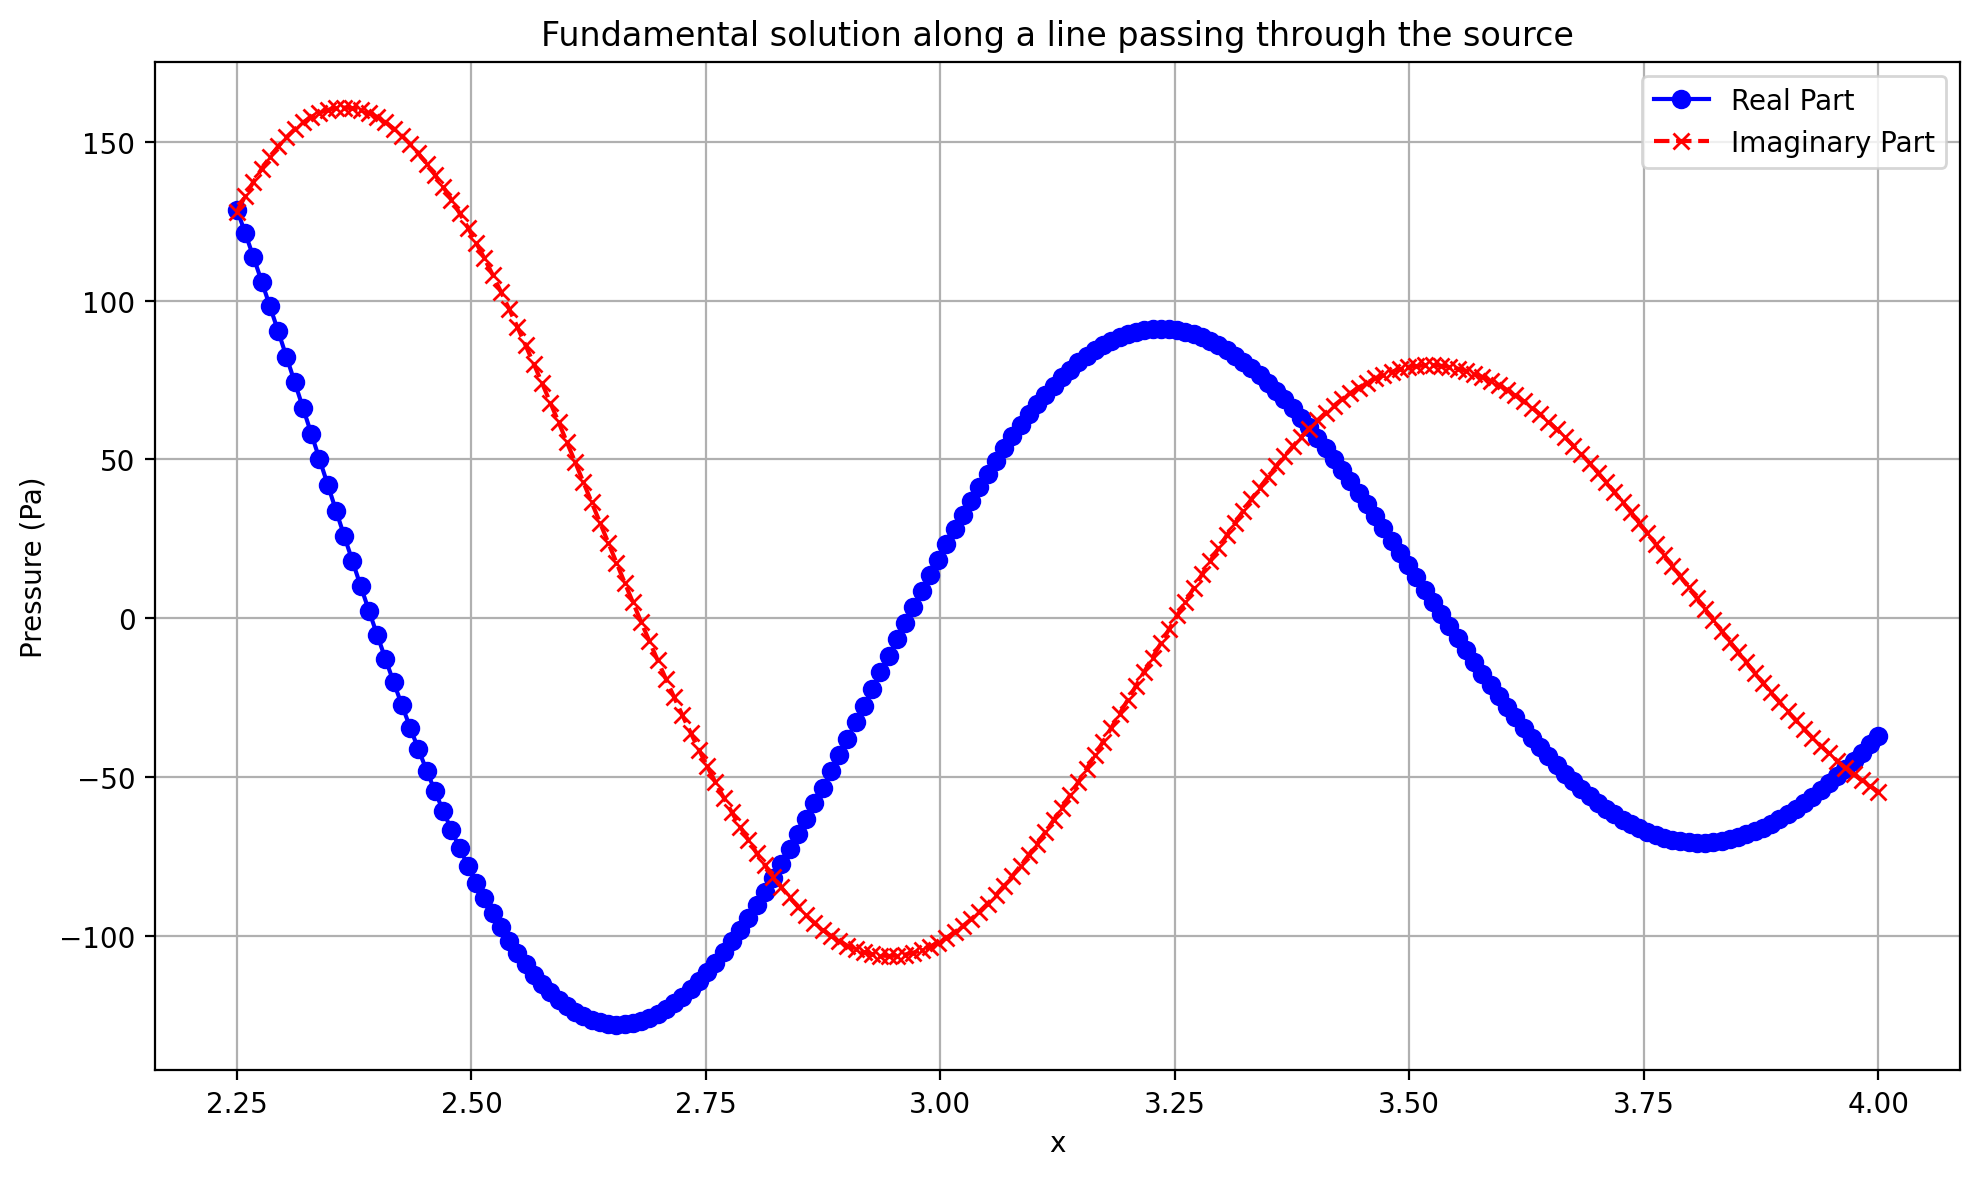

In [ ]:
# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(
    pts[:, 0], fund.real, label="Real Part", color="blue", linestyle="-", marker="o"
)
plt.plot(
    pts[:, 0],
    fund.imag,
    label="Imaginary Part",
    color="red",
    linestyle="--",
    marker="x",
)

# Add labels and title
plt.xlabel("x")
plt.ylabel("Pressure (Pa)")
plt.title("Fundamental solution along a line passing through the source")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
test_proj = problem.tabulate(cp.asarray(pts), batch_size=32)
measures = test_proj @ sol

100%|██████████| 7/7 [00:14<00:00,  2.02s/it]


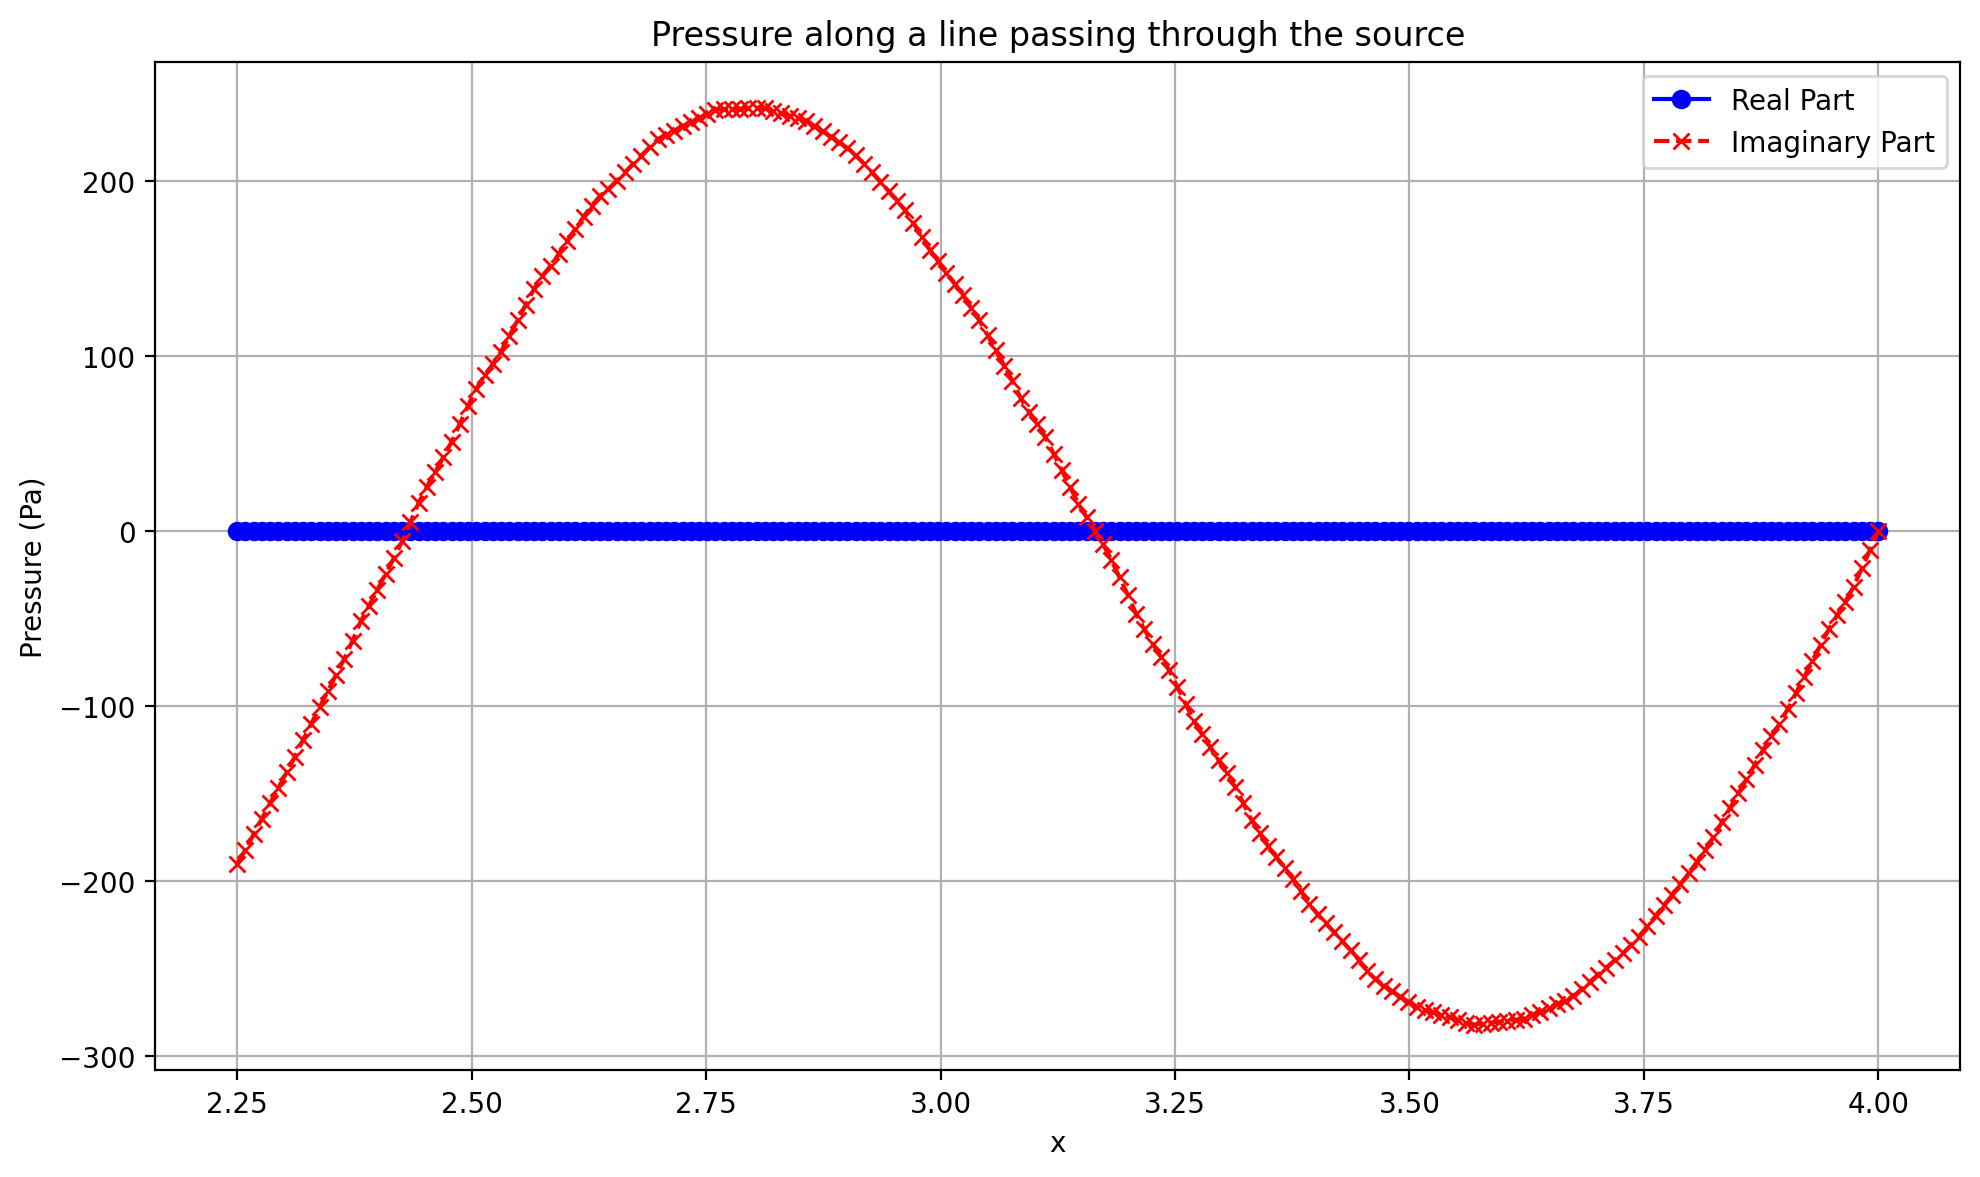

In [ ]:
# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(pts[:, 0], measures.real, label="Real Part", color="blue", linestyle="-", marker="o")
plt.plot(
  pts[:, 0],
  measures.imag,
  label="Imaginary Part",
  color="red",
  linestyle="--",
  marker="x",
)

# Add labels and title
plt.xlabel("x")
plt.ylabel("Pressure (Pa)")
plt.title("Pressure along a line passing through the source")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
xs = np.linspace(0, 4, 50)
zs = np.linspace(0, 3, 50)

In [ ]:
x, z = np.meshgrid(xs, zs)
x = x.flatten()
z = z.flatten()

In [ ]:
points = np.concatenate(
    [x[:, None], 1.01 * np.ones_like(x)[:, None], z[:, None]], axis=1
)

In [ ]:
pts_proj = problem.tabulate(cp.asarray(points), batch_size=38)
pts_proj

100%|██████████| 66/66 [02:19<00:00,  2.12s/it]


<2500x821337 sparse array of type '<class 'numpy.float64'>'
	with 9824 stored elements in Compressed Sparse Row format>

In [ ]:
test_sol = pts_proj @ sol.imag

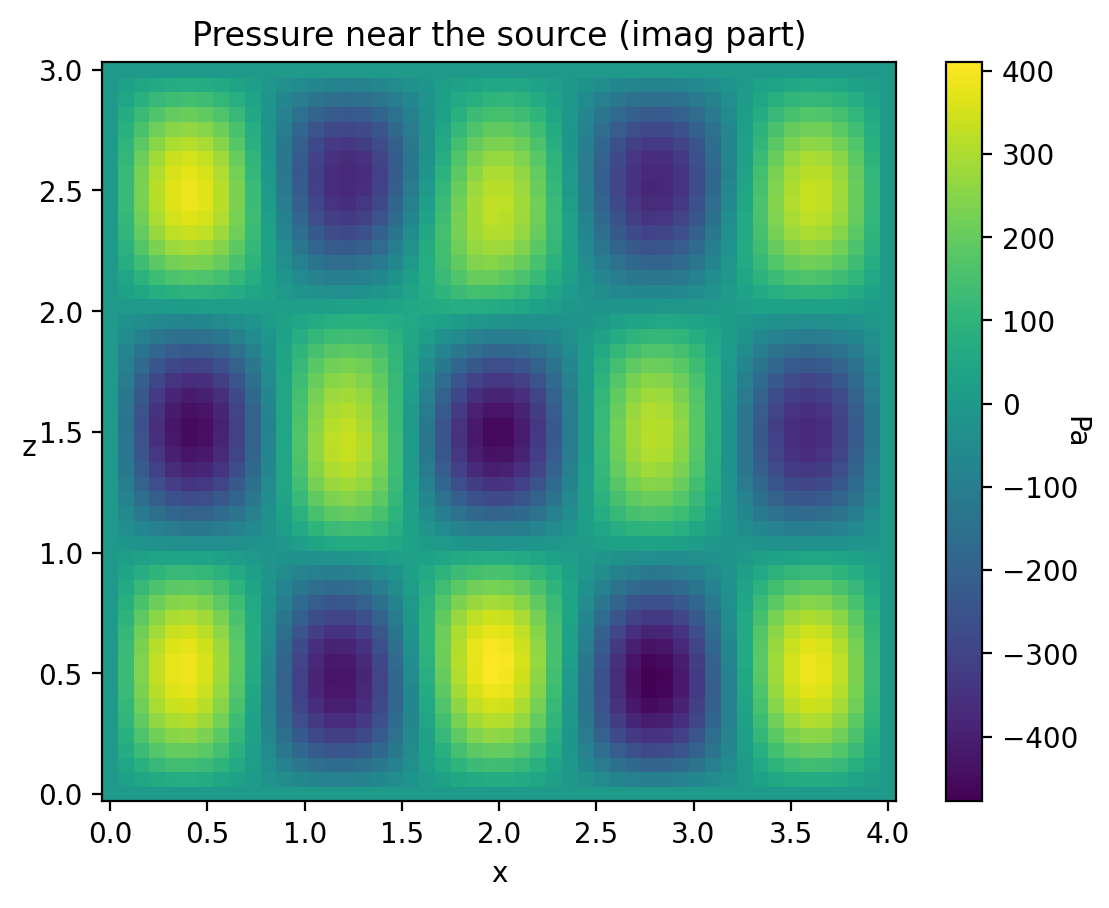

In [ ]:
fig, ax = plt.subplots()
plt.xlabel("x")
plt.ylabel("z", rotation=180)
plt.title("Pressure near the source (imag part)")
ctr = ax.pcolor(xs, zs, test_sol.reshape(50, 50))
cbar = fig.colorbar(ctr)
cbar.ax.set_ylabel("Pa", rotation=270)
plt.show()